In [261]:
import yaml
import pandas as pds
import seaborn as sns
import matplotlib.pyplot as plt
from SPARQLWrapper import SPARQLWrapper, JSON
from SPARQLWrapper.sparql_dataframe import get_sparql_dataframe

create list of obo namespaces  
obo_ontologies.yml downloaded from obofoundry.org

In [145]:
with open('obo_ontologies.yml', 'r') as f:
    obo_dict = yaml.safe_load(f)

In [146]:
namespaces = [o["id"].upper().strip() for o in obo_dict["ontologies"]]
len(namespaces)

256

example of first 5 namespaces

In [148]:
namespaces[:5]

['ADO', 'AGRO', 'AISM', 'AMPHX', 'APO']

set Ontobee endpoint and return format

In [152]:
endpoint = "http://sparql.hegroup.org/sparql/"

In [153]:
sparql = SPARQLWrapper(endpoint)
sparql.setReturnFormat(JSON)

define function to get RO relations from each ontology  
`namespace` is used to get the Ontobee graph

In [176]:
def make_query(namepace):
    q = """
    prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
    prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    prefix owl: <http://www.w3.org/2002/07/owl#>
    prefix merged: <http://purl.obolibrary.org/obo/merged/>
    
    select distinct ?namespace ?ro ?label where 
    {
      # set of BFO relations in RO
      values ?bfo_ro 
      {
        "obo:BFO_0000050" 
        "obo:BFO_0000051" 
        "obo:BFO_0000054" 
        "obo:BFO_0000055" 
        "obo:BFO_0000060" 
        "obo:BFO_0000062" 
        "obo:BFO_0000063" 
        "obo:BFO_0000066" 
        "obo:BFO_0000067" 
      }

      graph merged:%s 
      {
        ?r rdf:type owl:ObjectProperty; rdfs:label ?lbl .
      }
      # bind variables for display and ease of use
      bind(str(?lbl) as ?label) # removes lang tag and datatype from lable
      bind("%s" as ?namespace)  # display namespace being uses
      bind(replace(str(?r), "http://purl.obolibrary.org/obo/", "obo:") as ?ro) # use OBO curie
      
      # filter for RO or BFO/RO relations
      filter (strstarts(?ro, "obo:RO_") || ?ro in (?bfo_ro))
    }
    """ % (namepace, namepace)
    return q

In [177]:
# print(make_query("OHD")) # testing

create list of dataframes with query results for each ontology

In [178]:
dfs = []
for ns in namespaces:
    if ns in df.namespace.values:
        q = make_query(ns)
        dfs.append(get_sparql_dataframe(endpoint, q))

number of non-empty ontologies

In [179]:
len([df for df in dfs if len(df) > 0])

153

combine list into single dataframe  
note: some relations have more than one label  
e.g.: obo:BFO_0000062 -> "pecedd by", "preceded_by"

In [180]:
df = pds.concat(dfs, ignore_index=True)
df.head(10)

,namespace,ro,label
0,ADO,obo:RO_0002436,molecularly interacts with
1,ADO,obo:RO_0002213,positively regulates
2,AGRO,obo:BFO_0000054,realized in
3,AGRO,obo:BFO_0000055,realizes
4,AGRO,obo:BFO_0000063,precedes
5,AGRO,obo:BFO_0000067,contains process
6,AGRO,obo:BFO_0000051,has_part
7,AGRO,obo:BFO_0000051,has part
8,AGRO,obo:BFO_0000062,preceded by
9,AGRO,obo:BFO_0000062,preceded_by


save results for later use

In [181]:
df.to_csv('obo_ro_usage.tsv', sep='\t', index=False)

create temp dataframe of unique namepaces and labels  
note: filtering out Ro

In [182]:
temp_df  = obo_df[['namespace', 'ro']].query('namespace != "RO"').drop_duplicates()

In [183]:
len(temp_df)

12387

In [291]:
temp_df.namespace.value_counts()

MFMO       634
ONTONEO    363
OBA        280
UPHENO     269
MONDO      250
          ... 
EXO          2
CHMO         2
CHEBI        2
MFOEM        2
RXNO         1
Name: namespace, Length: 152, dtype: int64

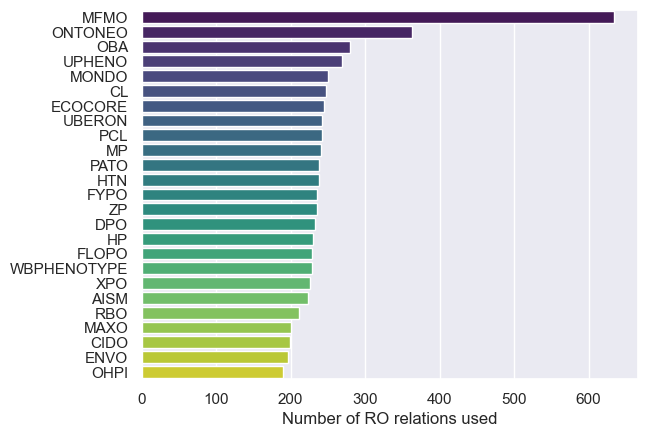

In [287]:
plot_df = pds.DataFrame(temp_df.namespace.value_counts().head(25).reset_index())
ax = sns.barplot(y='index', x='namespace', data=plot_df, palette='viridis') #color='steelblue')
ax.set(xlabel='Number of RO relations used', ylabel=None)
plt.show()

In [289]:
temp_df.query("namespace == 'GO'").value_counts()

namespace  ro             
GO         obo:BFO_0000050    1
           obo:BFO_0000051    1
           obo:BFO_0000066    1
           obo:RO_0002091     1
           obo:RO_0002092     1
           obo:RO_0002093     1
           obo:RO_0002211     1
           obo:RO_0002212     1
           obo:RO_0002213     1
dtype: int64